# Resultados Parciais

## Introdução

O VAEP tradicional apresenta limitações quando aplicado a certos tipos de jogadas que possuem forte dependência do contexto espacial e da movimentação dos jogadores — como é o caso dos cruzamentos. Diferentes regiões do campo, a quantidade de atacantes e defensores na área e o controle espacial no momento da ação são fatores que influenciam diretamente o valor e a efetividade de um cruzamento, mas que não são explicitamente considerados pelo modelo original.

Diante desse cenário, o objetivo do nosso projeto é estender o VAEP para incorporar variáveis contextuais específicas de cruzamentos, criando um modelo mais sensível ao ambiente tático e ao posicionamento dos jogadores.

Este relatório apresenta os resultados parciais alcançados até o momento, incluindo a preparação dos dados, a implementação de métricas espaciais como Pitch Control, e o enriquecimento do dataset com novas features extraídas dos dados de tracking. Também delineamos os próximos passos necessários para a construção e avaliação do modelo final.

## Dados

Neste projeto, estamos utilizando duas principais fontes de dados: dados de eventos e dados de tracking, que juntos permitem uma análise mais rica e contextualizada dos cruzamentos.

### Dados de Eventos

Os dados de eventos contêm o registro sequencial das ações realizadas durante as partidas, incluindo informações como tipo de ação, local em campo, jogador envolvido e o desfecho da jogada.

Principais características relevantes para o projeto:

- Tipo de ação: identificação de cruzamentos e suas consequências (ex.: finalização, perda de posse).
- Posição: localização do início de cada cruzamento.
- Resultado da ação: se a equipe manteve a posse após o cruzamento.
- Conversão para SPADL: os dados foram transformados para o formato SPADL, o que facilita a aplicação do framework VAEP.

In [1]:
from utils.io import read_events


events_df = read_events()
events_df.head()

,event_id,event_type,period_id,timestamp,end_timestamp,ball_state,ball_owning_team,team_id,player_id,coordinates_x,...,result,success,duel_type,goalkeeper_type,card_type,match_id,player_jersey_num,player_position_group_type,receiver_jersey_num,receiver_position_group_type
0,12926009,PASS,1,NaT,NaT,alive,5,5,15620,0.503105,...,COMPLETE,<NA>,<NA>,<NA>,<NA>,13335,17.0,LW,5.0,LCB
1,12926647,PASS,1,NaT,NaT,alive,5,5,4696,0.329743,...,INCOMPLETE,<NA>,<NA>,<NA>,<NA>,13335,5.0,LCB,28.0,RCB
2,12926642,DUEL,1,NaT,NaT,alive,11,5,14278,0.760200,...,LOST,<NA>,AERIAL,<NA>,<NA>,13335,28.0,RCB,NaN,NaN
3,12926642,DUEL,1,NaT,NaT,alive,11,11,284,0.760200,...,WON,<NA>,AERIAL,<NA>,<NA>,13335,6.0,LCB,NaN,NaN
4,12926642,DUEL,1,NaT,NaT,alive,11,5,13068,0.760200,...,LOST,<NA>,AERIAL,<NA>,<NA>,13335,30.0,RW,NaN,NaN


In [3]:
from utils import convert_to_spadl


spadl_df = convert_to_spadl(events_df)
spadl_df.head()

,game_id,original_event_id,period_id,time_seconds,team_id,player_id,start_x,start_y,end_x,end_y,type_id,result_id,bodypart_id,action_id,type_name,result_name,bodypart_name
0,13335,12926009,1,0,5,15620,52.826,34.309,34.327,29.666,0,1,0,0,pass,success,foot
1,13335,12926647,1,0,5,4696,34.623,31.107,79.821,50.021,0,0,0,1,pass,fail,foot
2,13335,12926642,1,0,5,14278,79.821,50.021,79.821,50.021,7,0,0,2,tackle,fail,foot
3,13335,12926642,1,0,11,284,79.821,50.021,79.821,50.021,7,1,0,3,tackle,success,foot
4,13335,12926642,1,0,5,13068,79.821,50.021,79.821,50.021,7,0,0,4,tackle,fail,foot


### Dados de Tracking

Os dados de tracking fornecem a posição (x, y) e a movimentação dos jogadores e da bola ao longo do tempo, com alta frequência de amostragem por frame.

Por conta de problemas relacionados a posição da bola, optamos por remover essa informação do tracking. Para isso, vamos utilizar as informações de posse de bola dos dados de eventos para ter esse controle.

Principais informações utilizadas:

- Posição dos jogadores: permitindo análises de ocupação de espaço, número de defensores e atacantes na área.
- Velocidade e direção: adicionadas como variáveis extras para enriquecer o contexto tático de cada cruzamento.
- Padronização da direção de ataque: todos os ataques foram reorientados para a mesma direção no campo, facilitando análises espaciais e comparações entre jogadas.

In [2]:
from utils.io import read_tracking


tracking_df = read_tracking(13335)
tracking_df.head()

,match_id,period,period_game_clock,frame_num,game_event_id,possession_event_id,element,jersey_number,x,y,team_id
0,13335.0,1.0,0.000221,4612.0,12931923.0,12926009.0,home,30.0,0.713,-18.790,5.0
1,13335.0,1.0,0.000221,4612.0,12931923.0,12926009.0,home,28.0,0.982,-25.356,5.0
2,13335.0,1.0,0.000221,4612.0,12931923.0,12926009.0,home,17.0,0.087,-0.606,5.0
3,13335.0,1.0,0.000221,4612.0,12931923.0,12926009.0,home,25.0,-0.439,14.148,5.0
4,13335.0,1.0,0.000221,4612.0,12931923.0,12926009.0,home,2.0,-18.955,-9.156,5.0


## Metodologia Parcial

O desenvolvimento do projeto tem seguido um pipeline incremental, começando pela preparação dos dados e chegando às primeiras análises contextuais sobre os cruzamentos. Abaixo detalhamos as principais etapas concluídas até o momento.

### Implementação do VAEP sobre Eventos

A primeira etapa foi a aplicação do framework VAEP original aos nossos dados de eventos convertidos para o formato SPADL. Essa implementação nos permitiu calcular os valores de cada ação (incluindo os cruzamentos) com base na probabilidade de marcar ou sofrer um gol após a ação.

In [7]:
import pickle

import pandas as pd

from utils.vaep import calculate_vaep_values


spadl_df = pd.read_parquet('./data/events_spadl.parquet')

with open("./models/vaep_scoring_model_20250615_020156.pkl", "rb") as f:
    scoring_model = pickle.load(f)
with open("./models/vaep_conceding_model_20250615_020156.pkl", "rb") as f:
    conceding_model = pickle.load(f)
spadl_with_vaep = calculate_vaep_values((scoring_model, conceding_model), spadl_df)

Calculando valores VAEP...
Valores VAEP calculados para 591728 de 591728 ações
Valor VAEP médio: 0.010236
Valor VAEP máximo: 0.837491
Valor VAEP mínimo: -0.495443


In [8]:
spadl_with_vaep.head()

,game_id,original_event_id,period_id,time_seconds,team_id,player_id,start_x,start_y,end_x,end_y,...,type_name,result_name,bodypart_name,home_team_id,away_team_id,vaep_value,offensive_value,defensive_value,scoring_prob,conceding_prob
0,13335,12926009,1,0,5,15620,52.826,34.309,34.327,29.666,...,pass,success,foot,5.0,11.0,0.011226,0.013899,-0.002673,0.013899,0.002673
1,13335,12926647,1,0,5,4696,34.623,31.107,79.821,50.021,...,pass,fail,foot,5.0,11.0,0.004402,0.009913,-0.005511,0.009913,0.005511
2,13335,12926642,1,0,5,14278,79.821,50.021,79.821,50.021,...,tackle,fail,foot,5.0,11.0,0.000682,0.009758,-0.009075,0.009758,0.009075
3,13335,12926642,1,0,11,284,25.179,17.979,25.179,17.979,...,tackle,success,foot,5.0,11.0,0.001409,0.011703,-0.010294,0.011703,0.010294
4,13335,12926642,1,0,5,13068,79.821,50.021,79.821,50.021,...,tackle,fail,foot,5.0,11.0,-0.009158,0.005040,-0.014198,0.005040,0.014198


In [9]:
def analyze_top_vaep_players(spadl_with_vaep, top_n=20):
    valid_actions = spadl_with_vaep[spadl_with_vaep['vaep_value'].notna()].copy()
    
    player_stats = valid_actions.groupby(['player_id']).agg({
        'vaep_value': ['count', 'sum', 'mean', 'std', 'min', 'max'],
        'offensive_value': ['sum', 'mean'],
        'defensive_value': ['sum', 'mean'],
        'scoring_prob': 'mean',
        'conceding_prob': 'mean'
    }).round(6)
    
    player_stats.columns = [
        'total_actions', 'vaep_total', 'vaep_mean', 'vaep_std', 'vaep_min', 'vaep_max',
        'offensive_total', 'offensive_mean', 'defensive_total', 'defensive_mean',
        'avg_scoring_prob', 'avg_conceding_prob'
    ]
    
    player_stats = player_stats.reset_index()
    
    min_actions = 50
    player_stats = player_stats[player_stats['total_actions'] >= min_actions]
    
    top_players_total = player_stats.nlargest(top_n, 'vaep_total')
    top_players_mean = player_stats.nlargest(top_n, 'vaep_mean')
    
    return player_stats, top_players_total, top_players_mean

player_stats, top_total, top_mean = analyze_top_vaep_players(spadl_with_vaep, top_n=20)

In [10]:
players_df = pd.read_csv("./data/players.csv")

In [11]:
players_ids = top_total["player_id"].tolist()
players_top = players_df.set_index("id").loc[players_ids].drop_duplicates().reset_index()
players_top.head(10)

,id,dob,firstName,height,lastName,nickname,positionGroupType
0,18,1996-06-22,Rodrigo,191.0,Hernández Cascante,Rodri,DM
1,448,1991-06-15,Pascal,181.0,Groß,Pascal Groß,CM
2,438,1991-11-21,Lewis,192.0,Dunk,Lewis Dunk,RCB
3,21,2000-05-28,Phil,171.0,Foden,Phil Foden,RW
4,163,2001-09-05,Bukayo,178.0,Saka,Bukayo Saka,RW
5,1688,1998-12-17,Martin,178.0,Ödegaard,Martin Ödegaard,AM
6,133,1994-09-08,Bruno,179.0,Fernandes,Bruno Fernandes,AM
7,596,2002-05-06,Cole,189.0,Palmer,Cole Palmer,AM
8,37,1991-07-08,Virgil,193.0,van Dijk,Virgil van Dijk,RCB
9,3924,1997-11-16,Bruno,182.0,Guimarães,Bruno Guimarães,DM


### Enriquecimento com Tracking: Velocidade e Direção dos Jogadores

Para melhorar a representação contextual das jogadas, adicionamos aos dados informações sobre velocidade e direção dos jogadores, extraídas dos dados de tracking. Essas variáveis são importantes para entender o nível de pressão, a dinâmica dos jogadores próximos e a preparação para a recepção de cruzamentos.

In [3]:
from utils.tracking import calculate_smoothed_velocity

cross_events = events_df[events_df["pass_type"] == "CROSS"]

tracking_with_speed_df = calculate_smoothed_velocity(tracking_df)
tracking_with_speed_df.head()

,match_id,period,period_game_clock,frame_num,game_event_id,possession_event_id,element,jersey_number,x,y,team_id,vx,vy
0,13335.0,1.0,0.000221,4612.0,12931923.0,12926009.0,home,1.0,-38.123,-0.452,5.0,0.566667,-0.091667
1,NaN,1.0,0.033587,4613.0,NaN,NaN,home,1.0,-38.100,-0.457,5.0,0.562500,-0.087500
2,NaN,1.0,0.066954,4614.0,NaN,NaN,home,1.0,-38.078,-0.461,5.0,0.560000,-0.080000
3,NaN,1.0,0.100321,4615.0,NaN,NaN,home,1.0,-38.055,-0.463,5.0,0.558333,-0.070833
4,NaN,1.0,0.133687,4616.0,NaN,NaN,home,1.0,-38.033,-0.466,5.0,0.557143,-0.064286


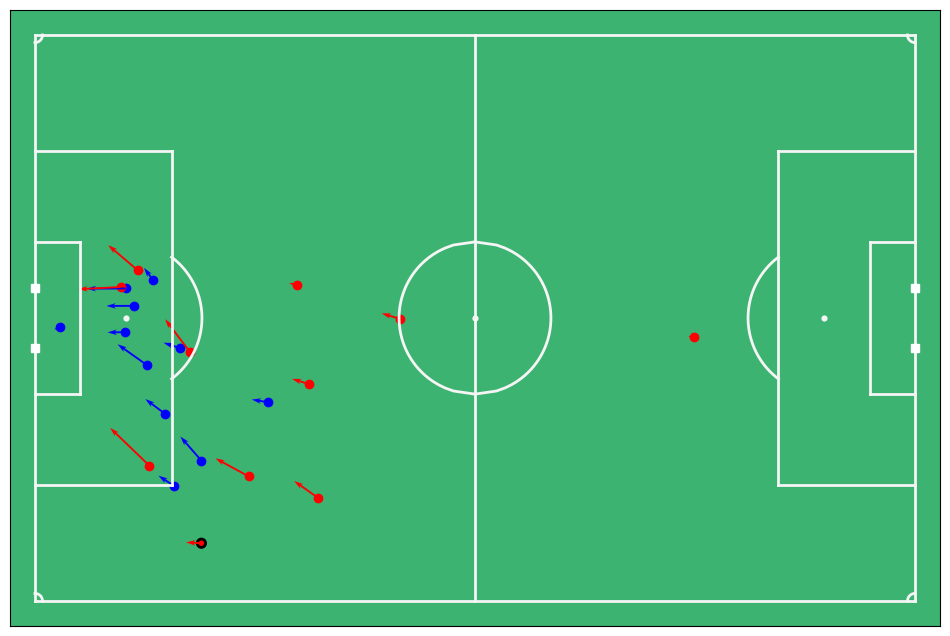

In [4]:
from utils.plot import plot_pitch

event = cross_events.iloc[2]
frame = tracking_with_speed_df[tracking_with_speed_df["possession_event_id"] == event["event_id"]]

player_jersey_num = event["player_jersey_num"]

fig, ax = plot_pitch()

home_team = frame[frame["element"] == "home"]
away_team = frame[frame["element"] == "away"]

# Plot dos jogadores
ax.scatter(home_team["x"], home_team["y"], color="blue")
ax.scatter(away_team["x"], away_team["y"], color="red")

# Destaque para o jogador com a bola
player_with_ball = frame[
    (frame["jersey_number"] == event["player_jersey_num"]) &
    (frame["team_id"] == event["team_id"])
]
ax.scatter(player_with_ball["x"], player_with_ball["y"], facecolors="none", edgecolors="black", linewidths=2)

for team_df, color in [(home_team, "blue"), (away_team, "red")]:
    ax.quiver(
        team_df["x"], team_df["y"],
        team_df["vx"], team_df["vy"],
        color=color,
        scale=50,
        width=0.002,
        headwidth=3, headlength=5, headaxislength=4,
    )

### Padronização da Direção de Cruzamento

Para permitir uma análise espacial consistente, os cruzamentos foram padronizados para ocorrerem na mesma direção (exemplo: da esquerda para a direita no campo). Essa transformação facilita comparações entre jogadas de diferentes jogos. Por enquanto, vamos manter apenas para os frames estaticos de cruzamentos. Em um futuro podemos optar por padronizar outros tipos de frames.

In [ ]:
std_cross_tracking_df = tracking_with_speed_df[tracking_with_speed_df["possession_event_id"].isin(cross_events["event_id"].tolist())]
std_cross_tracking_df = std_cross_tracking_df.sort_values(by=["frame_num", "element", "jersey_number"]).reset_index()
std_cross_tracking_df.head()

,index,match_id,period,period_game_clock,frame_num,game_event_id,possession_event_id,element,jersey_number,x,y,team_id,vx,vy
0,197869,NaN,1.0,181.481702,10051.0,12932919.0,12926871.0,away,2.0,-17.952,9.310,11.0,-0.546875,0.053125
1,701348,NaN,1.0,181.481702,10051.0,12932919.0,12926871.0,away,6.0,-41.688,-5.535,11.0,-0.809375,-0.690625
2,1012460,NaN,1.0,181.481702,10051.0,12932919.0,12926871.0,away,9.0,-43.091,-0.023,11.0,-0.356250,-0.050000
3,1451419,NaN,1.0,181.481702,10051.0,12932919.0,12926871.0,away,16.0,-41.686,-9.393,11.0,-0.493750,0.100000
4,1811417,NaN,1.0,181.481702,10051.0,12932919.0,12926871.0,away,17.0,-44.228,26.828,11.0,-0.471875,-0.271875


In [ ]:
from utils.tracking import standardize_crossings_direction

std_cross_tracking_df = standardize_crossings_direction(std_cross_tracking_df, cross_events[cross_events["match_id"] == 13335])
std_cross_tracking_df.head()

,index,match_id,period,period_game_clock,frame_num,game_event_id,possession_event_id,element,jersey_number,x,y,team_id,vx,vy
0,197869,NaN,1.0,181.481702,10051.0,12932919.0,12926871.0,away,2.0,17.952,-9.310,11.0,0.546875,-0.053125
1,701348,NaN,1.0,181.481702,10051.0,12932919.0,12926871.0,away,6.0,41.688,5.535,11.0,0.809375,0.690625
2,1012460,NaN,1.0,181.481702,10051.0,12932919.0,12926871.0,away,9.0,43.091,0.023,11.0,0.356250,0.050000
3,1451419,NaN,1.0,181.481702,10051.0,12932919.0,12926871.0,away,16.0,41.686,9.393,11.0,0.493750,-0.100000
4,1811417,NaN,1.0,181.481702,10051.0,12932919.0,12926871.0,away,17.0,44.228,-26.828,11.0,0.471875,0.271875


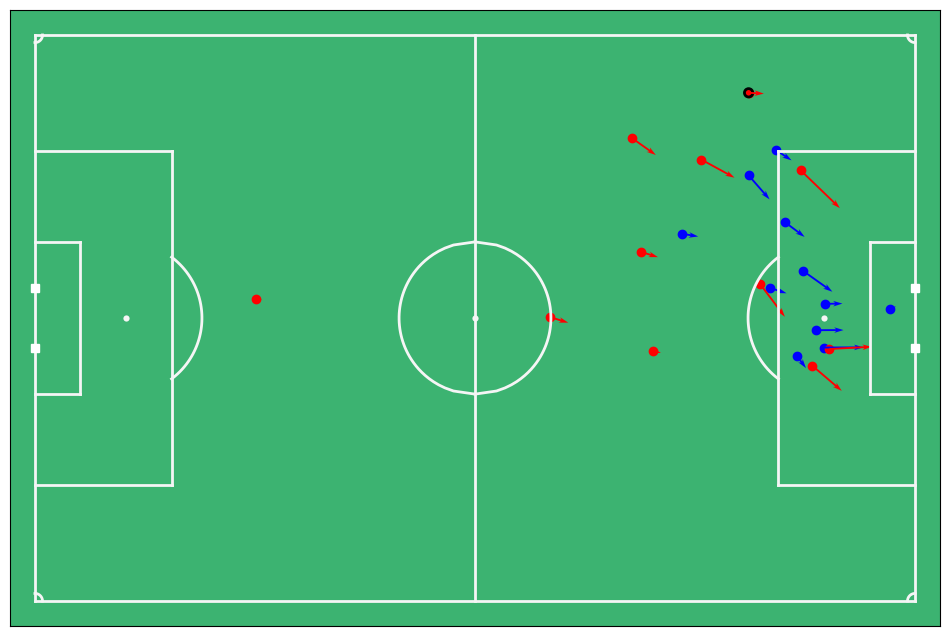

In [30]:

event = cross_events.iloc[2]
frame = std_cross_tracking_df[std_cross_tracking_df["possession_event_id"] == event["event_id"]]

player_jersey_num = event["player_jersey_num"]

fig, ax = plot_pitch()

home_team = frame[frame["element"] == "home"]
away_team = frame[frame["element"] == "away"]

# Plot dos jogadores
ax.scatter(home_team["x"], home_team["y"], color="blue")
ax.scatter(away_team["x"], away_team["y"], color="red")

# Destaque para o jogador com a bola
player_with_ball = frame[
    (frame["jersey_number"] == event["player_jersey_num"]) &
    (frame["team_id"] == event["team_id"])
]
ax.scatter(player_with_ball["x"], player_with_ball["y"], facecolors="none", edgecolors="black", linewidths=2)

for team_df, color in [(home_team, "blue"), (away_team, "red")]:
    ax.quiver(
        team_df["x"], team_df["y"],
        team_df["vx"], team_df["vy"],
        color=color,
        scale=50,
        width=0.002,
        headwidth=3, headlength=5, headaxislength=4,
    )

### Identificação de Cruzamentos e Definição de Sucesso

Implementamos uma lógica para identificar os cruzamentos a partir dos dados de eventos, considerando o tipo da ação e sua posição em campo.

Definimos o sucesso de um cruzamento como a situação em que a equipe manteve a posse de bola após o cruzamento, levando a uma nova ação ofensiva, como um passe ou finalização.

Abaixo o codigo que foi implementado para isso:

In [ ]:
def mark_cross_success(events_df):
    events = events_df.copy()
    events["cross_success"] = False

    events = events.sort_values(["match_id", "period_id", "timestamp"]).reset_index(drop=True)

    cross_indices = events[events["pass_type"] == "CROSS"].index

    for idx in cross_indices:
        if idx + 1 >= len(events):
            continue

        next_event = events.iloc[idx + 1]

        if  pd.notna(next_event["result"]) and next_event["result"] == "COMPLETE":
            events.at[idx, "cross_success"] = True

    return events

In [32]:
from utils.tracking import mark_cross_success


df = mark_cross_success(events_df)

cross_events = df[df["pass_type"] == "CROSS"]
cross_events.head()

,event_id,event_type,period_id,timestamp,end_timestamp,ball_state,ball_owning_team,team_id,player_id,coordinates_x,...,success,duel_type,goalkeeper_type,card_type,match_id,player_jersey_num,player_position_group_type,receiver_jersey_num,receiver_position_group_type,cross_success
56,12926871,PASS,1,NaT,NaT,alive,11,11,22,0.088524,...,<NA>,<NA>,<NA>,<NA>,13335,17.0,CM,16.0,CM,True
116,12927328,PASS,1,NaT,NaT,alive,5,5,270,0.740895,...,<NA>,<NA>,<NA>,<NA>,13335,24.0,CM,28.0,RCB,False
156,12927878,PASS,1,NaT,NaT,alive,11,11,22,0.150867,...,<NA>,<NA>,<NA>,<NA>,13335,17.0,CM,NaN,NaN,False
159,12927949,PASS,1,NaT,NaT,alive,11,11,22,0.115667,...,<NA>,<NA>,<NA>,<NA>,13335,17.0,CM,9.0,CF,False
485,12932318,PASS,1,NaT,NaT,alive,11,11,4661,0.243248,...,<NA>,<NA>,<NA>,<NA>,13335,25.0,RCB,NaN,NaN,False


In [35]:
cross_events[cross_events["match_id"] == 13335][["match_id", "team_id", "player_id", "cross_success"]]

,match_id,team_id,player_id,cross_success
56,13335,11,22,True
116,13335,5,270,False
156,13335,11,22,False
159,13335,11,22,False
485,13335,11,4661,False
505,13335,11,27,False
570,13335,5,270,False
582,13335,11,10715,False
940,13335,11,21,False
946,13335,11,27,False


In [37]:
cross_events[cross_events["match_id"] == 13336][["match_id", "team_id", "player_id", "cross_success"]]

,match_id,team_id,player_id,cross_success
1609,13336,2,163,False
1632,13336,2,163,False
1634,13336,2,163,False
1637,13336,2,163,False
1698,13336,2,163,False
1765,13336,2,163,False
1769,13336,2,163,False
1803,13336,2,1688,False
1858,13336,2,8022,False
1940,13336,2,163,False


In [38]:
cross_events[cross_events["match_id"] == 13337][["match_id", "team_id", "player_id", "cross_success"]]

,match_id,team_id,player_id,cross_success
3146,13337,19,2082,False
3206,13337,19,94,False
3363,13337,19,272,False
3427,13337,19,2063,False
3429,13337,19,274,False
3500,13337,19,276,False
3502,13337,19,274,False
3522,13337,1,304,False
3555,13337,1,7332,False
3601,13337,1,304,False


### Análise de Ocupação da Área

Para cada cruzamento identificado, foi calculado o número de atacantes e defensores presentes na área no momento da execução do cruzamento. Esse dado servirá como uma das principais features contextuais para a modelagem do valor da ação.

In [46]:
from utils.tracking import count_players_in_box


event = cross_events[cross_events["match_id"] == 13335].iloc[0]
attacking_team_id = event["team_id"]
frame = std_cross_tracking_df[std_cross_tracking_df["possession_event_id"] == event["event_id"]]

num_attackers, num_defenders = count_players_in_box(frame, attacking_team_id)

print(f"Numero de atacantes na area: {num_attackers}\nNumero de defensores na area: {num_defenders}")


Numero de atacantes na area: 5
Numero de defensores na area: 10


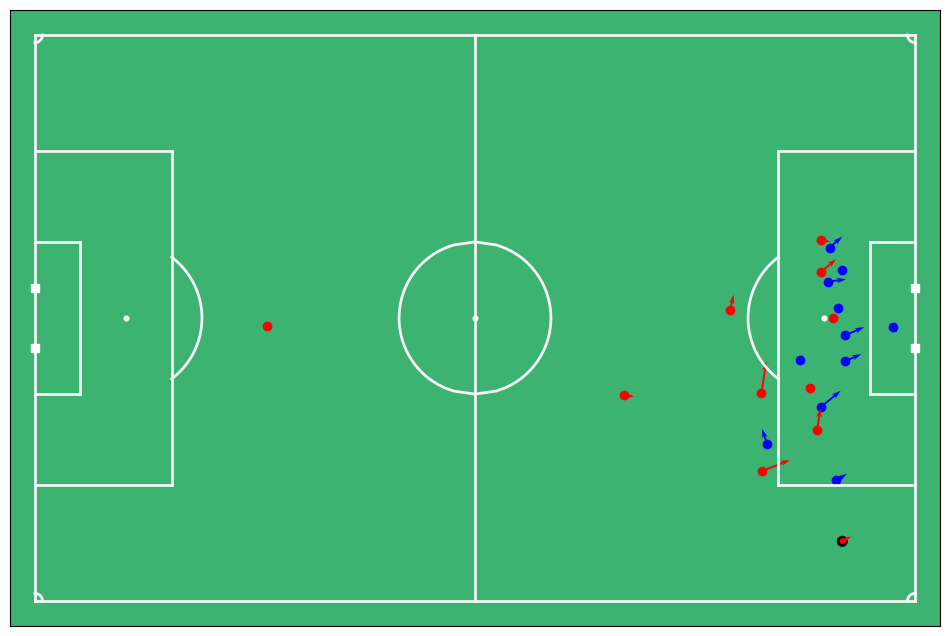

In [ ]:
fig, ax = plot_pitch()

home_team = frame[frame["element"] == "home"]
away_team = frame[frame["element"] == "away"]

ax.scatter(home_team["x"], home_team["y"], color="blue")
ax.scatter(away_team["x"], away_team["y"], color="red")

player_with_ball = frame[
    (frame["jersey_number"] == event["player_jersey_num"]) &
    (frame["team_id"] == event["team_id"])
]

ax.scatter(player_with_ball["x"], player_with_ball["y"], facecolors="none", edgecolors="black", linewidths=2)

for team_df, color in [(home_team, "blue"), (away_team, "red")]:
    ax.quiver(
        team_df["x"], team_df["y"],
        team_df["vx"], team_df["vy"],
        color=color,
        scale=50,
        width=0.002,
        headwidth=3, headlength=5, headaxislength=4,
    )

### Implementação Inicial de Pitch Control

Por fim, implementamos o cálculo de Pitch Control baseado no modelo de Javier Fernández, com foco no frame exato de cada cruzamento. Essa métrica permite quantificar a probabilidade de controle de cada equipe em diferentes regiões do campo, fornecendo uma visão mais precisa do contexto espacial ao redor da área.

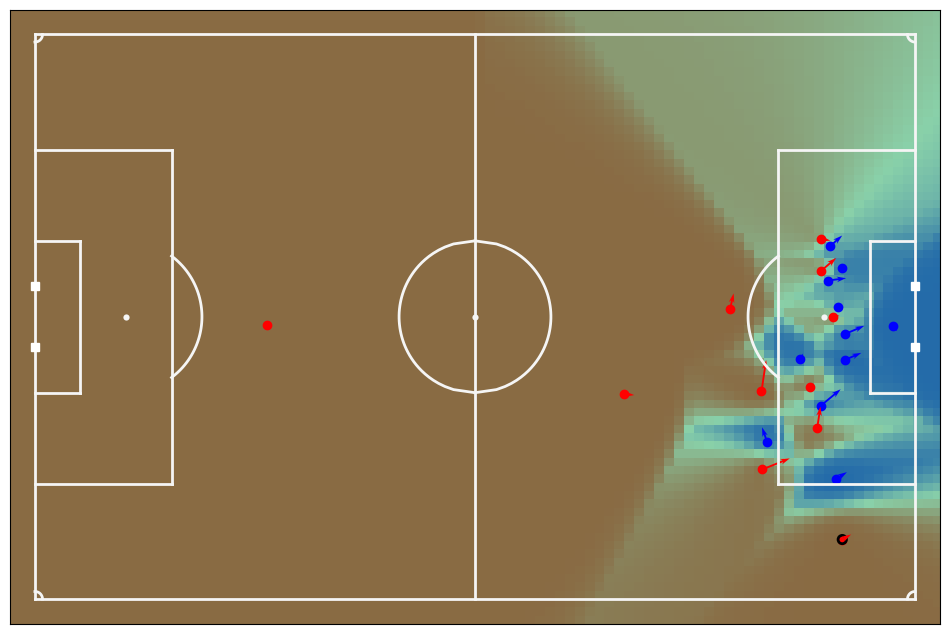

In [48]:
from utils.pc import generate_pitch_control_for_frame, prepare_pitch_control_input


event = cross_events[cross_events["match_id"] == 13335].iloc[0]
attacking_team_id = event["team_id"]
frame = std_cross_tracking_df[std_cross_tracking_df["possession_event_id"] == event["event_id"]]

player_with_ball = frame[
    (frame["jersey_number"] == event["player_jersey_num"]) &
    (frame["team_id"] == event["team_id"])
].iloc[0]

attacking_players, defending_players, ball_position = prepare_pitch_control_input(frame, attacking_team_id, (player_with_ball["x"], player_with_ball["y"]))

pc_surface = generate_pitch_control_for_frame(attacking_players, defending_players, ball_position)

fig, ax = plot_pitch()

ax.imshow(pc_surface, extent=[-60, 60, -40, 40], origin='lower', cmap='bwr', alpha=0.4)

home_team = frame[frame["element"] == "home"]
away_team = frame[frame["element"] == "away"]

ax.scatter(home_team["x"], home_team["y"], color="blue")
ax.scatter(away_team["x"], away_team["y"], color="red")

player_with_ball = frame[
    (frame["jersey_number"] == event["player_jersey_num"]) &
    (frame["team_id"] == event["team_id"])
]

ax.scatter(player_with_ball["x"], player_with_ball["y"], facecolors="none", edgecolors="black", linewidths=2)

for team_df, color in [(home_team, "blue"), (away_team, "red")]:
    ax.quiver(
        team_df["x"], team_df["y"],
        team_df["vx"], team_df["vy"],
        color=color,
        scale=50,
        width=0.002,
        headwidth=3, headlength=5, headaxislength=4,
    )

## Proximos Passos

Com as etapas iniciais já concluídas, os próximos passos do projeto estão focados em aprofundar a caracterização dos cruzamentos e integrar essas novas informações ao modelo VAEP.

### Clusterização dos Cruzamentos por Região da Área

Pretendemos realizar uma clusterização espacial dos cruzamentos, segmentando-os com base na região da área onde a bola foi direcionada. Esse agrupamento permitirá identificar diferentes tipos de cruzamento (ex.: primeiro pau, segundo pau, meio da área).

Para isso, será necessário decidir como representar a posição do cruzamento:

- Considerar apenas o ponto de origem e destino do cruzamento?
- Incluir a posição da bola no momento da execução?
- Considerar o Pitch Control na área-alvo?

### Engenharia de Features Contextuais

Além das variáveis já calculadas (como número de jogadores na área e Pitch Control), vamos explorar outras possíveis features relevantes, como:

- Distância entre o cruzador e a linha de gol.
- Densidade de defensores no raio de ação do cruzamento.
- Velocidade de aproximação dos atacantes na área.

### Extensão do VAEP para Cruzamentos

Com as novas features contextuais, a ideia é treinar um novo modelo VAEP que consiga capturar o valor específico dos cruzamentos, considerando não apenas o desfecho imediato da ação, mas também o contexto espacial e a configuração de jogadores no momento do passe.

### Avaliação e Validação

Por fim, vamos realizar uma avaliação quantitativa comparando o desempenho do novo modelo com o VAEP original. A ideia é verificar se a inclusão das novas variáveis realmente melhora a capacidade de predição do modelo em relação a gols futuros ou perda de posse.

Também planejamos realizar uma análise qualitativa, observando casos individuais de cruzamentos para avaliar se os valores atribuídos pelo modelo fazem sentido do ponto de vista tático.

## Considerações Finais

Até o momento, avançamos de forma consistente nas etapas iniciais do projeto, estruturando os dados, implementando o VAEP original e adicionando informações contextuais fundamentais para o entendimento e a avaliação de cruzamentos.

Já conseguimos enriquecer os dados com variáveis de tracking, padronizar a direção dos ataques, identificar cruzamentos e calcular características contextuais importantes como o número de jogadores na área e o Pitch Control no momento da ação.

O desafio agora está em transformar esse contexto em features que agreguem valor ao modelo, permitindo que o VAEP capture de forma mais precisa o impacto tático e estratégico dos diferentes tipos de cruzamento.

Nos próximos passos, a clusterização dos cruzamentos por região da área e a reavaliação do modelo VAEP com as novas features serão fundamentais para concluir o projeto com uma análise robusta e aplicável.

Continuamos confiantes de que a abordagem proposta trará uma contribuição relevante para o entendimento quantitativo dos cruzamentos no futebol, ampliando o potencial de aplicação do VAEP para contextos espaciais mais complexos.